In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from yellowbrick.target import ClassBalance
import seaborn as sns
import itertools
import xgboost as xgb
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [190]:
# Loading data from Wells Fargo
wells_df = pd.read_csv('data/KB1H1DSPRFMYMCUFXT09_header.txt', sep='|')


/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (40,41,42,43,62,73) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Loading the Census Tract (FIPS) dictionary from another notebook
%store -r FIPS_dict

# Dataset First Glance
* 1026755 rows, 85 columns
* Dataset contains a mix of nominal, ordinal, continuous and both high and low cardinality variables
* Some columns or column values will be irrelevant to the model or perfect predictors that need to be dropped

In [4]:
wells_df.describe()

,Record Identifier,Loan Type,Loan Purpose,Preapproval,Construction Method,Occupancy Type,Loan Amount,Action Taken,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Applicant or Borrower: 4,Ethnicity of Applicant or Borrower: 5,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 4,Ethnicity of Co-Applicant or Co-Borrower: 5,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Applicant or Borrower: 5,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race of Co-Applicant or Co-Borrower: 4,Race of Co-Applicant or Co-Borrower: 5,Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Total Points and Fees,Origination Charges,Discount Points,Lender Credits,Interest Rate,Prepayment Penalty Term,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Multifamily Affordable Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Automated Underwriting System: 3,Automated Underwriting System: 4,Automated Underwriting System: 5,Reverse Mortgage,Open-End Line of Credit,Business or Commercial Purpose
count,1026755.0,1.026755e+06,1.026755e+06,1026755.0,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026678e+06,1.026678e+06,1.022420e+06,43666.000000,756.000000,32.000000,10.000000,1.025294e+06,17441.000000,319.000000,4.000000,3.000000,1.026755e+06,1.026755e+06,1.024266e+06,52411.000000,3341.000000,367.000000,130.000000,1.025983e+06,24116.000000,1384.000000,138.000000,42.000000,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,925841.000000,1.026755e+06,287229.000000,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,72878.000000,19023.000000,2411.000000,587123.000000,0.0,588374.000000,166196.000000,265192.000000,708010.000000,31740.0,456724.000000,1.020518e+06,61036.000000,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,8.798830e+05,1.026755e+06,1.026755e+06,1505.000000,1.026755e+06,1.026755e+06,1.026755e+06,144021.000000,123537.0,0.0,0.0,1.026755e+06,1.026755e+06,1.026755e+06
mean,2.0,1.141138e+00,1.174022e+01,2.0,1.008377e+00,1.139754e+00,3.165218e+05,3.800118e+00,2.619660e+04,2.619681e+10,2.271685e+00,11.711354,13.010582,13.343750,13.800000,3.703004e+00,11.587868,12.877743,13.000000,13.666667,2.043026e+00,3.062117e+00,5.292666e+00,20.465437,22.673451,24.607629,24.446154,6.751281e+00,21.025419,23.387283,26.188406,28.357143,2.041977e+00,3.061838e+00,1.571603e+00,3.547926e+00,2.042056e+00,3.061660e+00,154.048498,7.592503e-01,0.428227,2.407511e+00,1.146633e+00,6.252027e+00,8.657559e+00,8.940914e+00,3.761108,3.675656,3.83865

In [5]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026755 entries, 0 to 1026754
Data columns (total 85 columns):
 #   Column                                                                                            Non-Null Count    Dtype  
---  ------                                                                                            --------------    -----  
 0   Record Identifier                                                                                 1026755 non-null  int64  
 1   Legal Entity Identifier (LEI)                                                                     1026755 non-null  object 
 2   Loan Type                                                                                         1026755 non-null  int64  
 3   Loan Purpose                                                                                      1026755 non-null  int64  
 4   Preapproval                                                                                       1026755 no

# Selecting target variable
Action Taken: 
1: Loan originated
2: Application approved but not accepted
3: Application denied
4: Application withdrawn by applicant
5: File closed for incompleteness
6: Purchased loan
7: Preapproval request denied
8: Preapproval request approved but not accepted

Interpreting which actions are 'approved:' 
1, 2, 6

Denied:
3

Irrelevant to model: 4, 5, 7, 8

In [191]:
# 'Action Taken' will be target - remove '4,5': Application withdrawn by applicant
wells_df = wells_df[~wells_df['Action Taken'].isin([4,5,7,8])]

In [192]:
# Simplify 'Action Taken' to approved or denied 
wells_df['Action Taken'] = wells_df['Action Taken'].map(lambda x: 0 if x ==3 else 1)

## Dropping Columns and Selecting specific rows
* Dropped columns with std of 0, indicating all rows == same value 
* Dropped columns where num of non-null rows >= 150
* Excluded business loans
* Excluded reverse mortgage, multifamily units, non-primary residence
* Dropped Record Identifier - redundant with LEI
* Dropped LEI - all entries are the same lending institution. If other lending instutions are compared later, this column will instead be encoded
* Excluded 2nd lien mortgages and open-end line of credit, then dropped those columns

##### Uncomment when loading for first time

In [213]:
# wells_df = wells_df.drop('Preapproval', axis=1)
# wells_df = wells_df.drop('Prepayment Penalty Term', axis=1)
# wells_df = wells_df.drop('Automated Underwriting System: 3', axis=1)
# wells_df = wells_df.drop('Automated Underwriting System: 4', axis=1)
# wells_df = wells_df.drop('Automated Underwriting System: 5', axis=1)
# wells_df = wells_df.drop('Total Points and Fees', axis=1)
# wells_df = wells_df.drop('Ethnicity of Applicant or Borrower: 4', axis=1)
# wells_df = wells_df.drop('Ethnicity of Applicant or Borrower: 5', axis=1)
# wells_df = wells_df.drop('Ethnicity of Co-Applicant or Co-Borrower: 4', axis=1)
# wells_df = wells_df.drop('Ethnicity of Co-Applicant or Co-Borrower: 5', axis=1)
# wells_df = wells_df.drop('Race of Applicant or Borrower: 5', axis=1)
# wells_df = wells_df.drop('Race of Co-Applicant or Co-Borrower: 4', axis=1)
# wells_df = wells_df.drop('Race of Co-Applicant or Co-Borrower: 5', axis=1)
# wells_df = wells_df[wells_df['Business or Commercial Purpose'] == 2]
# wells_df = wells_df.drop('Reverse Mortgage', axis=1)
# wells_df = wells_df.drop('Multifamily Affordable Units', axis=1)
# wells_df = wells_df[wells_df['Occupancy Type'] == 1]
# wells_df = wells_df.drop('Record Identifier', axis=1)
# wells_df = wells_df.drop('Age of Applicant >= 62', axis=1)
# wells_df = wells_df.drop('Age of Co-Applicant >= 62', axis=1)
# wells_df = wells_df.drop('Legal Entity Identifier (LEI)', axis=1)
# wells_df = wells_df.drop('Occupancy Type', axis=1)
# wells_df = wells_df.drop('Business or Commercial Purpose', axis=1)
# wells_df = wells_df[wells_df['Lien Status'] == 1]
# wells_df = wells_df[wells_df['Open-End Line of Credit'] == 2]
# wells_df = wells_df.drop('Lien Status', axis=1)
# wells_df = wells_df.drop('Open-End Line of Credit', axis=1)
# wells_df = wells_df[~wells_df['State'].isnull()]
# wells_df = wells_df.drop(['Ethnicity of Applicant or Borrower: 3', 'Ethnicity of Co-Applicant or Co-Borrower: 3',
#                          'Race of Applicant or Borrower: 3', 'Race of Applicant or Borrower: 4', 
#                          'Race of Co-Applicant or Co-Borrower: 3'], axis=1)
# wells_df = wells_df[wells_df['Census Tract'] != 99.0]
# wells_df = wells_df[wells_df['Age of Applicant or Borrower'].notnull()]

# Columns dropped based on colinearity

In [194]:
# # colinear with construction method
wells_df = wells_df.drop(['Manufactured Home Secured Property Type', 'Manufactured Home Land Property Interest'], axis=1)

# Colinear with property value
wells_df = wells_df.drop('Loan Amount', axis=1)

# # Colinear with Action Taken
wells_df = wells_df.drop(['HOEPA Status'], axis=1)

# # Geographic regions - keep Census Tract only. Highest correlation with target, better generalizability
wells_df = wells_df.drop(['State', 'County'], axis=1)

# # Colinear with DIR
wells_df = wells_df.drop(['Initially Payable to Your Institution', 'Submission of Application'], axis=1)

# Columns/Rows dropped because they were perfect predictors

In [195]:
wells_df = wells_df.drop('Reason for Denial: 1', axis=1)
wells_df = wells_df.drop('Reason for Denial: 2', axis=1)
wells_df = wells_df.drop('Reason for Denial: 3', axis=1)
wells_df = wells_df.drop('Reason for Denial: 4', axis=1)
wells_df = wells_df.drop('Total Loan Costs', axis=1)
wells_df = wells_df.drop('Origination Charges', axis=1)
wells_df = wells_df.drop('Discount Points', axis=1)
wells_df = wells_df.drop('Lender Credits', axis=1)
wells_df = wells_df.drop('Interest Rate', axis=1)
wells_df = wells_df.drop('Rate Spread', axis=1)
wells_df = wells_df.drop('Type of Purchaser', axis=1)
wells_df = wells_df[wells_df['Age of Applicant or Borrower'].notnull()]


In [10]:
wells_df.describe()

,Loan Type,Loan Purpose,Construction Method,Action Taken,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Income,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Automated Underwriting System: 1,Automated Underwriting System: 2
count,760256.000000,760256.000000,760256.000000,760256.000000,7.602560e+05,758145.000000,33216.000000,759533.000000,13716.000000,760256.000000,760256.000000,759575.000000,39899.000000,760022.000000,18791.000000,760256.000000,760256.000000,760256.000000,760256.000000,760256.000000,760256.000000,680882.000000,760256.000000,760256.000000,271441.000000,760253.000000,47564.00000,760256.00000,760256.000000,760256.000000,760256.000000,6.565160e+05,760256.000000,127104.000000
mean,1.189357,13.188146,1.010052,4.086766,2.662464e+10,2.260881,11.686356,3.678880,11.567148,2.064320,3.052306,5.278136,20.444798,6.724051,20.970784,2.064113,3.052240,1.599716,3.537582,2.064027,3.052190,143.509702,6.935155,8.692765,76.048734,337.816474,88.80275,1.99988,1.993184,1.999999,1.999903,4.792202e+05,4.919392,1.071335
std,0.549154,14.589401,0.099754,2.149107,1.666678e+10,1.223806,1.771795,1.551258,1.869984,0.293609,0.967708,2.788744,7.313002,2.372252,6.822032,0.294008,0.967814,0.885358,1.576915,0.294172,0.967894,368.534401,3.251763,1.895928,522.015454,57.719203,22.31902,0.01094,0.082278,0.001147,0.009865,7.819128e+05,1.710726,0.257385
min,1.000000,1.000000,1.000000,1.000000,1.001020e+09,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-44803.000000,1.000000,1.000000,0.003000,24.000000,1.00000,1.00000,1.000000,1.000000,1.000000,5.000000e+03,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.200500e+10,2.000000,11.000000,2.000000,11.000000,2.000000,2.000000,5.000000,21.000000,5.000000,21.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,64.000000,3.000000,9.000000,60.000000,360.000000,84.00000,2.00000,2.000000,2.000000,2.000000,2.150000e+05,5.000000,1.000000
50%,1.000000,1.000000,1.000000,6.000000,2.700305e+10,2.000000,11.000000,4.000000,11.000000,2.000000,3.000000,5.000000,22.000000,8.000000,22.000000,2.000000,3.000000,1.000000,4.000000,2.000000,3.000000,99.000000,9.000000,9.000000,76.209000,360.000000,84.00000,2.00000,2.000000,2.000000,2.000000,3.250000e+05,6.000000,1.000000
75%,1.000000,31.000000,1.000000,6.000000,4.201710e+10,2.000000,13.000000,5.000000,12.000000,2.000000,4.000000,5.000000,24.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,2.000000,4.000000,159.000000,9.000000,9.000000,82.400000,360.000000,120.00000,2.00000,2.000000,2.000000,2.000000,5.250000e+05,6.000000,1.000000
max,4.000000,32.000000,2.000000,6.000000,7.801097e+10,14.000000,14.000000,14.000000,14.000000,3.000000,4.000000,44.000000,44.000000,44.000000,44.000000,3.000000,4.000000,6.000000,6.000000,3.000000,4.000000,135268.

# Condensing high cardinality columns
* The Census Tract column contains ~65K unique values. These were mapped to 10 'primary codes' which indicate if a region is rural, urban, metropolitan, etc. 
* Race and Ethnicity columns both allow the applicant to specify a more specific value. For example, an applicant can select Asian (2) or more specifically Chinese(22), etc. Because this column will be onehotencoded, I'm going to simplify these columns to the top-level categories:
    - American Indian or Alaska Native
    - Asian
    - Black or African American
    - Native Hawaiian or Other Pacific Islander
    - White

In [14]:
# race category condensing helper function

def race_condense(x): 
    if x> 10 and x < 20:
        x == 1
    elif x> 20 and x < 30:
        x == 2
    elif x> 30 and x < 40:
        x == 3
    elif x> 40 and x < 50:
        x == 4
    else: 
        x == x

In [196]:
# Code '6' or '7' as np.nan
wells_df['Race of Applicant or Borrower: 1'] = wells_df['Race of Applicant or Borrower: 1'] \
                                                            .map(lambda x: np.nan if (x == 6 or x == 7) else x)

wells_df['Race of Applicant or Borrower: 1'] = wells_df['Race of Applicant or Borrower: 1'].apply(lambda x: 1 if (x> 10 and x < 20)
                                                  else x)

wells_df['Race of Applicant or Borrower: 1'] = wells_df['Race of Applicant or Borrower: 1'].apply(lambda x: 2 if (x> 20 and x < 30)
                                                  else x)
wells_df['Race of Applicant or Borrower: 1'] = wells_df['Race of Applicant or Borrower: 1'].apply(lambda x: 4 if (x> 40 and x < 50)
                                                  else x)

In [197]:
# Code '6' or '7' as np.nan
wells_df['Race of Applicant or Borrower: 2'] = wells_df['Race of Applicant or Borrower: 2'] \
                                                            .map(lambda x: np.nan if (x == 6 or x == 7) else x)

wells_df['Race of Applicant or Borrower: 2'] = wells_df['Race of Applicant or Borrower: 2'].apply(lambda x: 1 if (x> 10 and x < 20)
                                                  else x)

wells_df['Race of Applicant or Borrower: 2'] = wells_df['Race of Applicant or Borrower: 2'].apply(lambda x: 2 if (x> 20 and x < 30)
                                                  else x)
wells_df['Race of Applicant or Borrower: 2'] = wells_df['Race of Applicant or Borrower: 2'].apply(lambda x: 4 if (x> 40 and x < 50)
                                                  else x)

In [198]:
# Code '6' or '7' or '8' as np.nan
wells_df['Race of Co-Applicant or Co-Borrower: 1'] = wells_df['Race of Co-Applicant or Co-Borrower: 1'] \
                                                            .map(lambda x: np.nan if (x == 6 or x == 7 or x ==8) else x)

wells_df['Race of Co-Applicant or Co-Borrower: 1'] = wells_df['Race of Co-Applicant or Co-Borrower: 1'].apply(lambda x: 1 if (x> 10 and x < 20)
                                                  else x)

wells_df['Race of Co-Applicant or Co-Borrower: 1'] = wells_df['Race of Co-Applicant or Co-Borrower: 1'].apply(lambda x: 2 if (x> 20 and x < 30)
                                                  else x)
wells_df['Race of Co-Applicant or Co-Borrower: 1'] = wells_df['Race of Co-Applicant or Co-Borrower: 1'].apply(lambda x: 4 if (x> 40 and x < 50)
                                                  else x)

In [199]:
# Code '6' or '7' or '8' as np.nan
wells_df['Race of Co-Applicant or Co-Borrower: 2'] = wells_df['Race of Co-Applicant or Co-Borrower: 2'] \
                                                            .map(lambda x: np.nan if (x == 6 or x == 7 or x ==8) else x)

wells_df['Race of Co-Applicant or Co-Borrower: 2'] = wells_df['Race of Co-Applicant or Co-Borrower: 2'].apply(lambda x: 1 if (x> 10 and x < 20)
                                                  else x)

wells_df['Race of Co-Applicant or Co-Borrower: 2'] = wells_df['Race of Co-Applicant or Co-Borrower: 2'].apply(lambda x: 2 if (x> 20 and x < 30)
                                                  else x)
wells_df['Race of Co-Applicant or Co-Borrower: 2'] = wells_df['Race of Co-Applicant or Co-Borrower: 2'].apply(lambda x: 4 if (x> 40 and x < 50)
                                                  else x)

In [200]:
# Hispanic: 1, Not hispanic: 2, nan: 3, 4
wells_df['Ethnicity of Applicant or Borrower: 1'] = wells_df['Ethnicity of Applicant or Borrower: 1'] \
                                                            .map(lambda x: np.nan if (x == 3 or x == 4) else x)

wells_df['Ethnicity of Applicant or Borrower: 1'] = wells_df['Ethnicity of Applicant or Borrower: 1'] \
                                                                            .apply(lambda x: 1 if x !=2 else x)

In [201]:
wells_df['Ethnicity of Applicant or Borrower: 2'] = wells_df['Ethnicity of Applicant or Borrower: 2'] \
                                                            .map(lambda x: np.nan if (x == 3 or x == 4) else x)

wells_df['Ethnicity of Applicant or Borrower: 2'] = wells_df['Ethnicity of Applicant or Borrower: 2'] \
                                                                            .apply(lambda x: 1 if x !=2 else x)

In [202]:
# Hispanic: 1, Not hispanic: 2, nan: 3, 4, 5
wells_df['Ethnicity of Co-Applicant or Co-Borrower: 1'] = wells_df['Ethnicity of Co-Applicant or Co-Borrower: 1'] \
                                                            .map(lambda x: np.nan if (x==3 or x==4 or x==5) else x)

wells_df['Ethnicity of Co-Applicant or Co-Borrower: 1'] = wells_df['Ethnicity of Co-Applicant or Co-Borrower: 1'] \
                                                                            .apply(lambda x: 1 if x !=2 else x)

In [203]:
wells_df['Ethnicity of Co-Applicant or Co-Borrower: 2'] = wells_df['Ethnicity of Co-Applicant or Co-Borrower: 2'] \
                                                            .map(lambda x: np.nan if (x==3 or x==4 or x==5) else x)

wells_df['Ethnicity of Co-Applicant or Co-Borrower: 2'] = wells_df['Ethnicity of Co-Applicant or Co-Borrower: 2'] \
                                                                            .apply(lambda x: 1 if x !=2 else x)

## Census Tract mapping


In [204]:
wells_df['Census Tract'] = wells_df['Census Tract'].astype(int)

In [205]:
wells_df['Census Tract'] = wells_df['Census Tract'].astype(str)

In [206]:
wells_df['Census Tract'] = wells_df['Census Tract'].map(FIPS_dict)


In [207]:
wells_df['Census Tract'].value_counts()

1.0     412404
2.0      53778
4.0      18720
7.0       6546
5.0       6538
10.0      6291
3.0       2526
8.0       1672
6.0       1207
9.0        796
99.0         6
Name: Census Tract, dtype: int64

# Handling null values
* Using ```pd.crosstab```, noticed that every null ```Age``` value is approved for a loan. Originally, I was going to use ```KNNImputer``` for this variable, but because the null values are perfect predictors, they will be dropped. 
* ```Deb-to-Income Ratio``` contains nearly 50% null values

### Age

In [138]:
wells_df['Age of Applicant or Borrower'].value_counts()

35-44    166831
25-34    146779
45-54    127611
55-64     88649
65-74     45747
8888      39437
8888      19355
<25       16185
>74       13838
Name: Age of Applicant or Borrower, dtype: int64

In [208]:
# Convert int(8888) and str(8888) to nan
wells_df['Age of Applicant or Borrower'] = wells_df['Age of Applicant or Borrower'] \
                                                    .apply(lambda x: np.nan if (x == 8888 or x == '8888') else x)

In [141]:
wells_df['Age of Applicant or Borrower'].value_counts()

35-44    166831
25-34    146779
45-54    127611
55-64     88649
65-74     45747
<25       16185
>74       13838
Name: Age of Applicant or Borrower, dtype: int64

In [145]:
pd.crosstab(wells_df['Age of Applicant or Borrower'].isnull(), wells_df['Action Taken'])

Action Taken,0,1
Age of Applicant or Borrower,,
False,67795,537845


In [ ]:
age_dict = {'<25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65-74': 5, '>74': 6}

<BarContainer object of 9 artists>

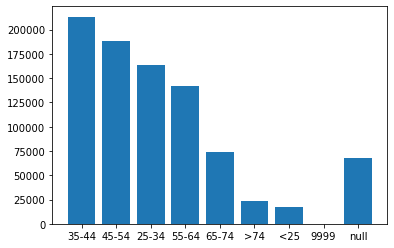

In [28]:
# Plotting to visualize num nan: ~7% of entries
fig, ax = plt.subplots()
ax.bar(age['index'], age['Age of Applicant or Borrower'])

In [209]:
wells_df['Age of Applicant or Borrower'] = wells_df['Age of Applicant or Borrower'] \
                                                .map(lambda x: '0-25' if x == '<25' else x)

In [210]:
wells_df['Age of Applicant or Borrower'] = wells_df['Age of Applicant or Borrower'] \
                                                .map(lambda x: '75-100' if x == '>74' else x)

In [211]:
wells_df['Age of Applicant or Borrower'].value_counts()

35-44     166831
25-34     146781
45-54     127615
55-64      88649
65-74      45747
0-25       16185
75-100     13838
Name: Age of Applicant or Borrower, dtype: int64

In [217]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
age_df = wells_df[['Age of Applicant or Borrower']].to_numpy()
enc.fit(age_df)
enc.categories_
enc_age_arr = enc.transform(wells_df[['Age of Applicant or Borrower']].to_numpy())
len(enc_age_arr)

605646

In [218]:
wells_df.head()

,Loan Type,Loan Purpose,Construction Method,Action Taken,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Co-Applicant or Co-Borrower,Income,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Total Units,Automated Underwriting System: 1,Automated Underwriting System: 2
37925,1,4,1,1,NaN,2.0,1.0,1.0,1.0,2,4,1.0,NaN,NaN,NaN,2,4,2,5,2,4,55-64,9999,NaN,9,9,NaN,NaN,351.0,NaN,2,2,2,2,NaN,1,6,NaN
37926,1,4,1,1,1.0,2.0,1.0,1.0,1.0,2,4,1.0,3.0,NaN,NaN,2,4,2,5,2,4,45-54,9999,NaN,9,9,NaN,NaN,156.0,NaN,2,2,2,2,NaN,1,6,NaN
37927,2,4,1,1,1.0,1.0,1.0,1.0,1.0,2,4,5.0,NaN,NaN,NaN,2,4,2,5,2,4,55-64,9999,NaN,9,9,NaN,NaN,359.0,NaN,2,2,2,2,NaN,1,6,NaN
37928,1,4,1,1,1.0,1.0,1.0,1.0,1.0,2,4,5.0,NaN,NaN,NaN,2,4,1,5,2,4,35-44,9999,65.0,1,10,20%-<30%,NaN,297.0,NaN,2,2,2,2,NaN,1,6,NaN
37929,2,4,2,1,2.0,1.0,1.0,1.0,1.0,2,4,5.0,NaN,NaN,NaN,2,4,2,5,2,4,45-54,9999,NaN,9,9,NaN,NaN,360.0,NaN,2,2,2,2,NaN,1,6,NaN


In [219]:
wells_df['Age of Applicant or Borrower'] = enc_age_arr

In [221]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605646 entries, 37925 to 982220
Data columns (total 38 columns):
 #   Column                                                                                            Non-Null Count   Dtype  
---  ------                                                                                            --------------   -----  
 0   Loan Type                                                                                         605646 non-null  int64  
 1   Loan Purpose                                                                                      605646 non-null  int64  
 2   Construction Method                                                                               605646 non-null  int64  
 3   Action Taken                                                                                      605646 non-null  int64  
 4   Census Tract                                                                                      463201 non-nul

In [26]:
# There are two '8888' entries possible (str or int). Combined into one column called 'null'
 
age = pd.DataFrame(wells_df['Age of Applicant or Borrower'].value_counts()).T
age['null'] = age[8888] + age['8888']
age = age.drop(columns=[8888, '8888'], axis=1)
age = age.T.reset_index()
age

,index,Age of Applicant or Borrower
0,35-44,213214
1,45-54,187796
2,25-34,163052
3,55-64,141880
4,65-74,74310
5,>74,23816
6,<25,16966
7,9999,1
8,null,68137


## Debt-to-Income Ratio

AttributeError: 'DataFrame' object has no attribute 'value_counts'

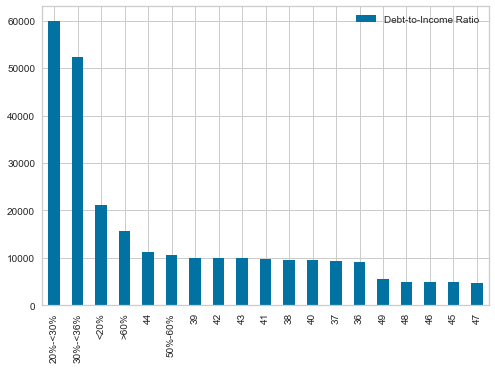

In [157]:
DIR = pd.DataFrame(wells_df['Debt-to-Income Ratio'].value_counts())
DIR.plot(kind='bar')


## Handling categorical variables
* ```States``` column contains 17 nan that were dropped
* Convert ```States``` to numerical
* ```Visual Observation of Race/Ethnicity``` columns:
    * Combined codes 2,3 (```Race```) and and treated this as a yes/no question (i.e. was race noted by observation rather than self-report?)
    * Shortened these column names
* ```Age``` columns - mapped using ordinal ranking
* ```Debt-to-Income``` 
    * This column had both string and integer values. The string values were intervals that include values less than 36% and greater than 50%. Values between 36-50% were expressed as integers. My assumption is that each point will affect mortgage lending (whether approval, rate, etc) significantly enough that the integers were intentionally not binned. So, rather than creating additional bins, I changed the bins to the median value or the closest value above or below in increments of 5. 


In [5]:
# create dataframe containing all unique entries of wells_df
states = wells_df['State'].unique().astype(str)

In [8]:
wells_df['State'].isnull().sum().sum()

17

In [7]:
states = np.sort(wells_df['State'].unique().astype(str))
states

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype='<U2')

In [8]:
# Cast to list to map str to int
states = list(states)

In [9]:
# Create a mapper dictionary and apply numerical encoding to 'State' column
state_mapper = {}
for idx, state in enumerate(states): 
    state_mapper[state] = idx

In [10]:
wells_df['State'] = wells_df['State'].map(state_mapper)

In [190]:
# checking if rows where the Race of the applicant differs from the visual race column
# It appears the visual observation is only used if not reported by applicant. Will use encoding. 
diff_race = wells_df[wells_df['Race of Applicant or Borrower: 1'] != wells_df['Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname']
    ]

In [14]:
wells_df['Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname'].value_counts()

2    596080
3     58792
1      9566
Name: Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname, dtype: int64

In [106]:
wells_df = wells_df.rename(columns = {'Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname': 'Race Visual Obs'})

In [16]:
wells_df['Race Visual Obs'].value_counts()

2    596080
3     58792
1      9566
Name: Race Visual Obs, dtype: int64

In [12]:
# 1: observation made, 0: observation not made
wells_df['Race Visual Obs'] = wells_df['Race Visual Obs'].map(lambda x: 1 if x == 1 else 0)

In [18]:
wells_df['Race Visual Obs'].value_counts()

0    654872
1      9566
Name: Race Visual Obs, dtype: int64

In [13]:
# Debt-to-Income Ratio: some values are expressed as a range, other are expressed exactly. 

DIR_mapper = {'20%-<30%': 25, '30%-<36%': 33, '>60%': 65, '<20%': 15, '50%-60%': 55}


wells_df['Debt-to-Income Ratio'] = wells_df['Debt-to-Income Ratio'].map(lambda x: DIR_mapper[x] if x in DIR_mapper else int(x), na_action='ignore')

In [20]:
wells_df['Debt-to-Income Ratio'].value_counts()

25.0    59981
33.0    52295
15.0    21158
65.0    15775
44.0    11228
55.0    10672
39.0    10091
42.0    10009
43.0     9944
41.0     9781
38.0     9664
40.0     9573
37.0     9438
36.0     9223
49.0     5533
48.0     5038
46.0     4896
45.0     4890
47.0     4780
Name: Debt-to-Income Ratio, dtype: int64

# General EDA
* Dataset now down to 811975 rows 
* ```Census Tract``` refers to a geographic region
* ```Age of Applicant``` contains ~65,000 nan values. Used KNN Imputation
* Create scattermatrix to check for colinearity

In [18]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664438 entries, 0 to 1005019
Data columns (total 53 columns):
 #   Column                                                                                            Non-Null Count   Dtype  
---  ------                                                                                            --------------   -----  
 0   Loan Type                                                                                         664438 non-null  int64  
 1   Loan Purpose                                                                                      664438 non-null  int64  
 2   Construction Method                                                                               664438 non-null  int64  
 3   Loan Amount                                                                                       664438 non-null  int64  
 4   Action Taken                                                                                      664438 non-null  

In [27]:
64673/age['Age of Applicant or Borrower'].sum()*100

7.273395923398398

In [66]:
wells_df[wells_df['Age of Applicant or Borrower'] == 8888]

,Legal Entity Identifier (LEI),Loan Type,Loan Purpose,Construction Method,Occupancy Type,Loan Amount,Action Taken,State,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race Visual Obs,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Applicant >= 62,Age of Co-Applicant or Co-Borrower,Age of Co-Applicant >= 62,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Origination Charges,Discount Points,Lender Credits,Interest Rate,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Total Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Open-End Line of Credit,Business or Commercial Purpose
0,Wells Fargo,2,5,1,1,85000,1,GA,13067.0,1.306703e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.500,NaN,NaN,360.0,NaN,2,2,2,2,105000.0,3,5,1,3,3,6,NaN,2,2
1,Wells Fargo,1,5,1,1,5000,1,NJ,34003.0,3.400304e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.375,NaN,NaN,360.0,NaN,2,2,2,2,175000.0,3,5,1,3,3,6,NaN,2,2
2,Wells Fargo,1,5,1,1,65000,1,SC,45007.0,4.500701e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250,NaN,NaN,480.0,NaN,2,2,2,2,95000.0,3,5,1,3,3,6,NaN,2,2
3,Wells Fargo,2,5,1,1,115000,1,FL,12081.0,1.208100e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.500,NaN,NaN,360.0,NaN,2,2,2,2,155000.0,3,5,1,3,3,6,NaN,2,2
4,Wells Fargo,2,5,1,1,205000,1,SC,45091.0,4.509106e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,2,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000,NaN,NaN,360.0,NaN,2,2,2,2,215000.0,3,5,1,3,3,6,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57339,Wells Fargo,2,5,1,1,145000,1,RI,44003.0,4.400302e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500,NaN,NaN,360.0,NaN,2,2,2,2,195000.0,3,5,1,3,3,6,NaN,2,2
57340,Wells Fargo,2,5,1,1,65000,1,PA,42107.0,4.210700e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN

In [22]:
wells_df['Age of Applicant or Borrower'].isnull().sum()

58792

In [17]:
wells_df['Age of Co-Applicant or Co-Borrower'] = wells_df['Age of Co-Applicant or Co-Borrower'].map(age_dict, na_action='ignore')

In [18]:
wells_df['Age of Applicant or Borrower'].isna().sum()

58794

In [19]:
wells_df['Age of Applicant or Borrower'].value_counts()

2.0    192005
1.0    162160
3.0    150441
4.0    106316
5.0     55605
6.0     17592
0.0     17343
Name: Age of Applicant or Borrower, dtype: int64

In [28]:
wells_df['Ethnicity of Applicant or Borrower: 3'].notnull().sum()

470

# Simplifying Race and Ethnicity columns

In [112]:
# Convert N/A and 'not provided' from numerical to nan
wells_df['Race of Applicant or Borrower: 1'] = wells_df['Race of Applicant or Borrower: 1'].map(lambda x: np.nan if (x==6 or x==7) else x, na_action='ignore')

In [114]:
# 122,365 nan values. Drop because these will be used to evaluate for bias later, so imputing might be unwise
wells_df['Race of Applicant or Borrower: 1'].isnull().sum()

122365

In [179]:
# Create a binary 'Minority' column
wells_df['Minority Applicant'] = wells_df['Race of Applicant or Borrower: 1'].map(lambda x: 0 if x==5 else 1, na_action='ignore')

In [180]:
wells_df['Action Taken'].value_counts()

1    664438
Name: Action Taken, dtype: int64

In [ ]:
# Drop all other race-related columns, including co-applicant
columns = ['Race of Applicant or Borrower: 1', 'Race of Applicant or Borrower: 2', 'Race of Applicant or Borrower: 3'
          'Race of Applicant or Borrower: 4', 'Race of Co-Applicant or Co-Borrower: 1', 
           'Race of Co-Applicant or Co-Borrower: 2', 'Race of Co-Applicant or Co-Borrower: 3']

In [230]:
# pickle the dataframe because KNN took a long time to run
# wells_df.to_pickle('wells_df.pkl')

In [231]:
wells_df['Age of Applicant or Borrower'].isnull().sum()

0

In [33]:
len(wells_df['State'].unique())

54

### Check to see which columns contain only one value
* Drop these columns in the drop cell, above

In [25]:
lst = []
for col in wells_df.columns:
    if len(wells_df[col].unique()) ==1: 
        lst.append(col)

In [40]:
lst

['Legal Entity Identifier (LEI)',
 'Occupancy Type',
 'Business or Commercial Purpose']

In [46]:
wells_df['Open-End Line of Credit'].value_counts()

2    665268
1    146724
Name: Open-End Line of Credit, dtype: int64

## Need to see if there are any columns that are exclusively associated with loan approval or denial
* Keep in DF: 
    * Total Loan Costs
    * Loan Type
* Delete: 
    * Lender Credits
    * Reasons for Denial
    * Total Loan Costs
    * Origination Charges
    * Discount Points
    * Lender Credits
    * Interest Rate

In [62]:
len_1_lst = []
len_2_lst = []
for col in wells_df.columns:
    if col == 'Action Taken': 
        continue
    else: 
        check_df = wells_df[wells_df[col].notnull()]
        if len(check_df['Action Taken'].value_counts() == 1):
            len_1_lst.append(col)
        elif len(check_df['Action Taken'].value_counts() == 2): 
            len_2_lst.append(col)



In [88]:
check = wells_df[wells_df['Applicant or Borrower - Name and Version of Credit Scoring Model'].notnull()]
check['Action Taken'].value_counts()

1    652497
0    159478
Name: Action Taken, dtype: int64

In [140]:
wells_df.head()

,Loan Type,Loan Purpose,Construction Method,Action Taken,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race Visual Obs,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Co-Applicant or Co-Borrower,Income,Type of Purchaser,Rate Spread,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Total Units,Automated Underwriting System: 1,Automated Underwriting System: 2,Legal Entity Identifier (LEI),Minority Applicant
0,2,5,1,1,1.306703e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,2.525645,NaN,NaN,0,NaN,9,9,NaN,NaN,360.0,NaN,2,2,2,2,105000.0,1,6,NaN,Wells Fargo,1
1,1,5,1,1,3.400304e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,2.525645,NaN,NaN,0,NaN,9,9,NaN,NaN,360.0,NaN,2,2,2,2,175000.0,1,6,NaN,Wells Fargo,1
2,1,5,1,1,4.500701e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,2.525645,NaN,NaN,0,NaN,9,9,NaN,NaN,480.0,NaN,2,2,2,2,95000.0,1,6,NaN,Wells Fargo,1
3,2,5,1,1,1.208100e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,2.525645,NaN,NaN,0,NaN,9,9,NaN,NaN,360.0,NaN,2,2,2,2,155000.0,1,6,NaN,Wells Fargo,1
4,2,5,1,1,4.509106e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,2.525645,NaN,NaN,2,NaN,9,9,NaN,NaN,360.0,NaN,2,2,2,2,215000.0,1,6,NaN,Wells Fargo,1


In [36]:
check = wells_df[wells_df['Origination Charges'].isnull()]
check['Action Taken'].value_counts()

0    159478
1    113128
Name: Action Taken, dtype: int64

# Baseline model
There are many nan values in the ethnicity and race variables, and because I will be evaluating for bias, I don't want to drop these values, even though they are few. First, I will create a baseline model and evaluate several algorithms for accuracy before adjusting the way nan values are handled. For the baseline model, I'll fill nan values with zeroes and use a StandardScaler. 
* After running the baseline model, accuracy and recall were 100% for all algorithms. Looked for data leakage and found there were "reason for denial" columns that might be affecting the prediction. Dropped those from the X dataset and reran the base model. This decreased recall to 99.995%

In [159]:
wells_base = wells_df.fillna(0)
# wells_base.columns

In [160]:
# feature (X) and target(y) matrices
X = wells_base.drop(['Action Taken'], axis=1)
y = wells_base['Action Taken']

In [161]:
y.value_counts()

1    537845
0     67795
Name: Action Taken, dtype: int64

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify=y, random_state=42)

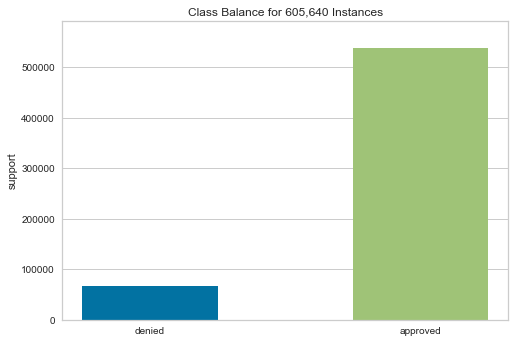

In [163]:
# Class imbalance on entire dataset
visualizer = ClassBalance(labels=['denied', 'approved'])

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show() 

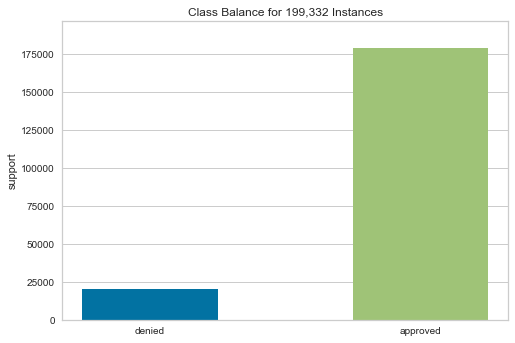

In [50]:
# Class imbalance on holdout
visualizer = ClassBalance(labels=['denied', 'approved'])

visualizer.fit(y_test)        # Fit the data to the visualizer
visualizer.show()

In [164]:
# 6645 entries
subset_wells = wells_base[::100]


In [170]:
subset_wells = subset_wells.fillna(0)

In [165]:
# feature (X) and target(y) matrices: confirmed both 6645 rows
X_sub = subset_wells.drop(['Action Taken'], axis=1)
y_sub = subset_wells['Action Taken']

In [166]:
## Create holdout sample
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.30, shuffle=True, stratify=y_sub)

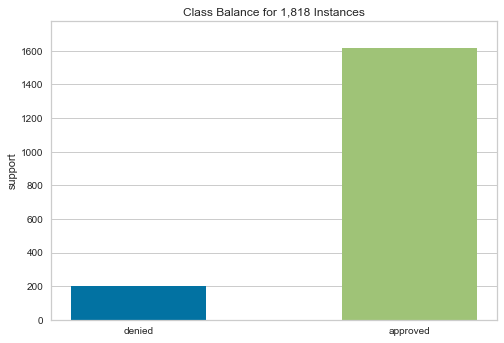

In [167]:
# Class imbalance on subset
visualizer = ClassBalance(labels=['denied', 'approved'])

visualizer.fit(y_test_sub)        # Fit the data to the visualizer
visualizer.show()

In [38]:
cor = subset_wells.corr()

cor_tf = cor.applymap(lambda x: True if abs(x)> 0.75 else False)

cor_tf
    

,Loan Type,Loan Purpose,Construction Method,Action Taken,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race Visual Obs,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Co-Applicant or Co-Borrower,Income,Type of Purchaser,Rate Spread,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Automated Underwriting System: 1,Automated Underwriting System: 2
Loan Type,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Loan Purpose,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Construction Method,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Action Taken,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Census Tract,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ethnicity of Applicant or Borrower: 1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ethnicity of Applicant or Borrower: 2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ethnicity of Applicant or Borrower: 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ethnicity of Co-Applicant or Co-Borrower: 1,False,False,False,False,False,False,False,False,True,False,False,False,Tr

In [39]:
cor_dict = {}
for col in cor_tf.columns:
    cor_dict[str(col)] = list(cor_tf[cor_tf[str(col)] == True].index)

# list(cor_tf[cor_tf['Loan Type'] == True].index)

In [160]:
for k, v in cor_dict.items(): 
    if len(v) > 1: 
        print(k,v)

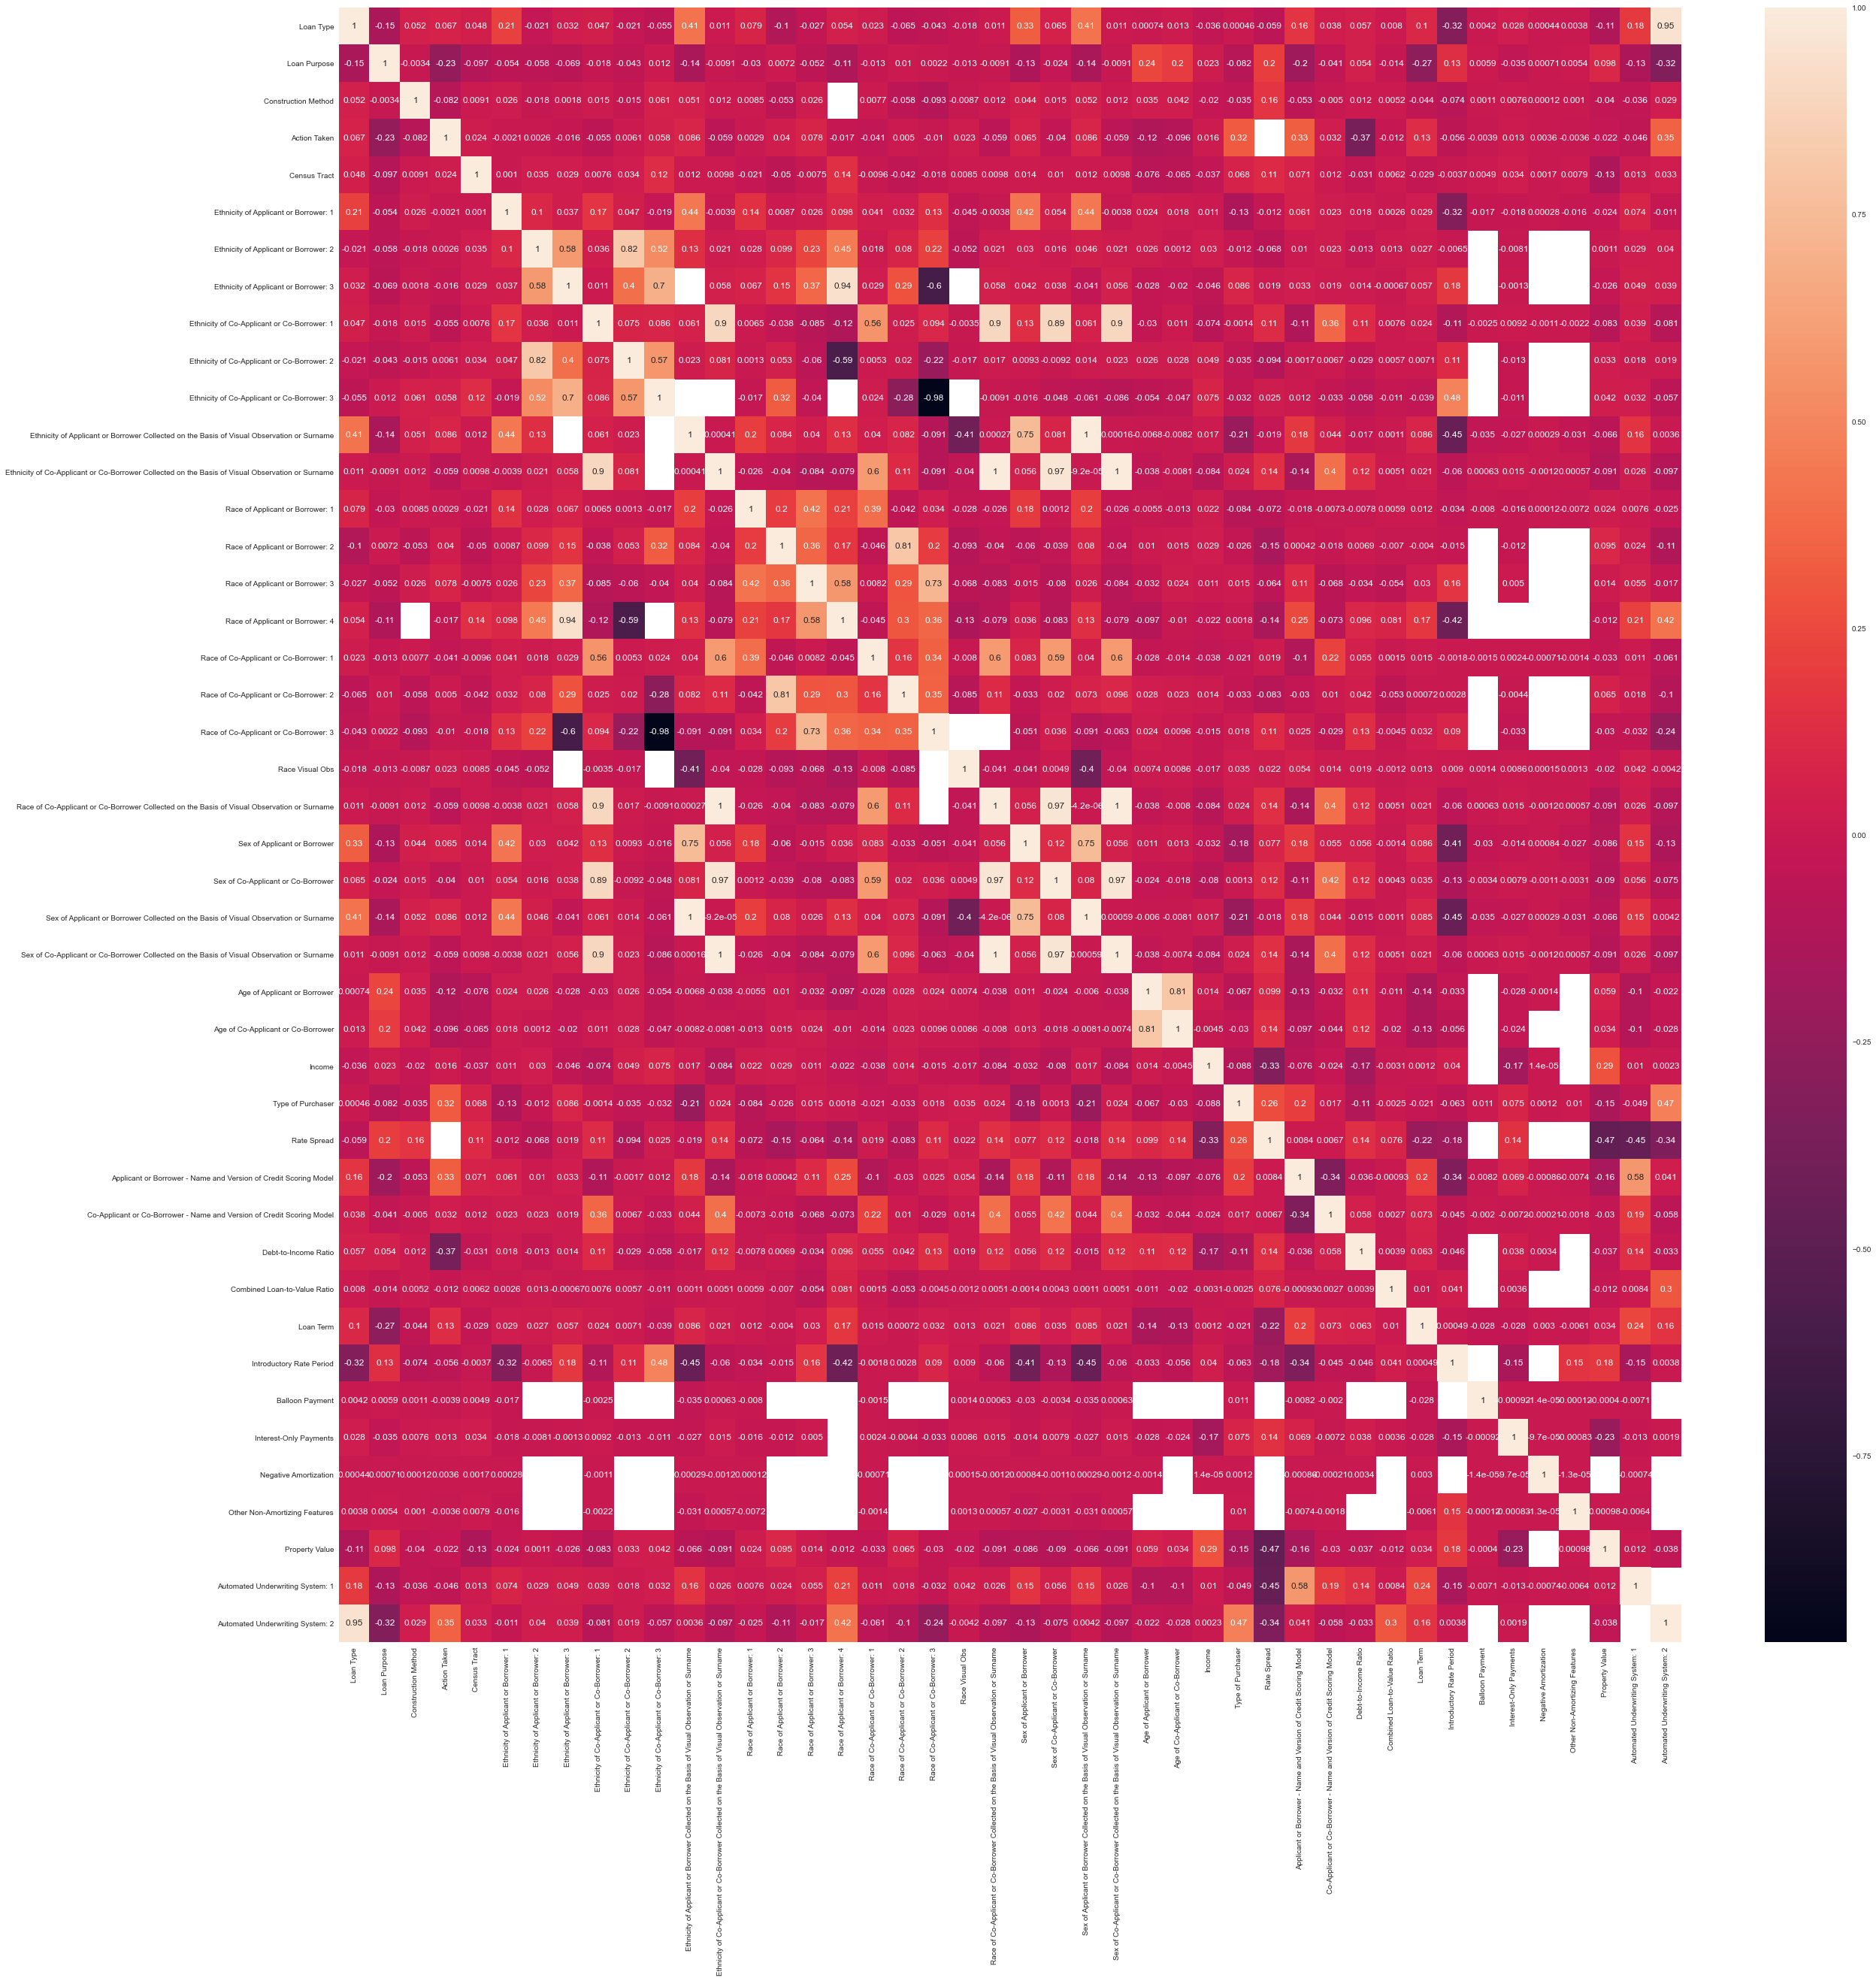

In [83]:
import seaborn as sns
cor = wells_df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(cor, annot=True)
plt.savefig('corr_matrix_3');

In [168]:
kf=5

In [75]:
# Logistic Regression
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegressionCV(solver='liblinear'))])
lr_grid_params = {}
lr_grid = GridSearchCV(lr_pipe, lr_grid_params, cv=kf, scoring = 'recall')
lr_grid.fit(X_train_sub, y_train_sub)


Logistic Regression Recall: 0.9832775919732442


In [87]:
print(f'Logistic Regression Recall training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print("Logistic Regression Recall test subset: {}".format(lr_grid.score(X_test_sub, y_test_sub)))
print(f'Logistic Regression Recall full test set: { lr_grid.score(X_test, y_test)}')

Logistic Regression Recall training subset: 0.9799235181644359
Logistic Regression Recall test subset: 0.9832775919732442
Logistic Regression Recall full test set: 0.9791276753839535


In [176]:
y.unique()

array([1])

In [174]:
# # Random Forest

rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
rf_grid_params = {}
rf_grid = GridSearchCV(rf_pipe, rf_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'roc_auc')
rf_grid.fit(X_train_sub, y_train_sub) 


ValueError: got predict_proba of shape (466, 1), but need classifier with two classes for roc_auc_score scoring

In [117]:
print(f'Random Forest Recall train subset: {rf_grid.score(X_train_sub, y_train_sub)}')
print("Random Forest Recall test subset: {}".format(rf_grid.score(X_test_sub, y_test_sub)))
print(f'Random Forest Recall full test set: { rf_grid.score(X_test, y_test)}')

Random Forest Recall train subset: 1.0
Random Forest Recall test subset: 0.9992502787068005
Random Forest Recall full test set: 0.9988757579799744


In [80]:
# Stochastic Gradient Descent - ran almost instantaneously
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier(loss='log'))])
sgd_pipe.fit(X_train_sub, y_train_sub)
print("SGD Classifier: {}".format(sgd_pipe.score(X_test_sub, y_test_sub)))

SGD Classifier: 0.9428284854563691


In [91]:
print(f'SGD Classifier Recall train subset: {sgd_pipe.score(X_train_sub, y_train_sub)}')
print("SGD Classifier Recall test subset: {}".format(sgd_pipe.score(X_test_sub, y_test_sub)))
print(f'SGD Classifier Recall full test set: { sgd_pipe.score(X_test, y_test)}')

SGD Classifier Recall train subset: 0.9419479681788863
SGD Classifier Recall test subset: 0.9428284854563691
SGD Classifier Recall full test set: 0.9423524572070716


In [ ]:
# Gradient Boosted Trees

# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# should only use either min_samples_leaf or min_weight_fraction_leaf
# max_depth should be tuned using CV (use this or max_leaf_nodes, if both one ignored)
# max_features = sqrt(N)
grid_params = {}
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', GradientBoostingClassifier())])

gb_grid = GridSearchCV(X_train, grid_params, cv = 5, scoring = 'recall')
gb_grid.fit(X_train_sub, y_train_sub)
print("GB Classifier: {}".format(gb_grid.score(X_test_sub, y_test_sub)))

In [46]:
# XGBoost

# data_dmatrix = xgb.DMatrix(data=X_train, label=y, enable_categorical=True)
# X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_train, y, test_size=0.2, random_state=123, stratify=y)
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(X_train_x ,y_train_x)
# print("XGBoost: {}".format(xg_reg.score(X_test_x, y_test_x)))

# Tuning Random Forest

In [169]:
# Random Forest

rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(n_jobs=-1, 
                                                                        oob_score=True, random_state=42))])
rf_grid_params = {'classifier__max_features': [6,7,8,9], 'classifier__n_estimators': [200,250],
                 'classifier__min_samples_leaf': [50, 60, 70]}
rf_grid = GridSearchCV(rf_pipe, rf_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'recall')
rf_grid.fit(X_train_sub, y_train_sub) 


/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 

ValueError: could not convert string to float: '35-44'

In [93]:
print(f'Random Forest Recall train subset: {rf_grid.score(X_train_sub, y_train_sub)}')
print("Random Forest Recall test subset: {}".format(rf_grid.score(X_test_sub, y_test_sub)))
print(f'Random Forest Recall full test set: { rf_grid.score(X_test, y_test)}')

Random Forest Recall train subset: 0.999282982791587
Random Forest Recall test subset: 0.9983277591973244
Random Forest Recall full test set: 0.998407758962641


In [94]:
rf_grid.best_params_

{'classifier__max_features': 6,
 'classifier__min_samples_leaf': 60,
 'classifier__n_estimators': 250}

In [97]:
# Updating model based on best parameters

rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(min_samples_leaf = 60, 
                                                                                        n_jobs=-1, oob_score=True, 
                                                                                        random_state=42))])
rf_grid_params = {'classifier__max_features': [3,4,5,6], 'classifier__n_estimators': [250, 300],
                 'classifier__criterion': ['gini', 'entropy']}
rf_grid = GridSearchCV(rf_pipe, rf_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'recall')
rf_fitted = rf_grid.fit(X_train_sub, y_train_sub) 


In [99]:
rf_fitted.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_features': 3,
 'classifier__n_estimators': 250}

In [98]:
print(f'Random Forest Recall train subset: {rf_fitted.score(X_train_sub, y_train_sub)}')
print("Random Forest Recall test subset: {}".format(rf_fitted.score(X_test_sub, y_test_sub)))
print(f'Random Forest Recall full test set: { rf_fitted.score(X_test, y_test)}')

Random Forest Recall train subset: 1.0
Random Forest Recall test subset: 1.0
Random Forest Recall full test set: 1.0


In [132]:
feat_import = rf_fitted.best_estimator_.named_steps['classifier'].feature_importances_
len(feat_import)

44

In [131]:
feature_importance = pd.Series(feat_import, index= wells_df.columns)
feature_importance.sort_values(inplace = True)
feature_importance.plot(kind = 'barh', figsize=(20,20))

ValueError: Length of passed values is 44, index implies 47.

In [129]:
feat_df = pd.DataFrame.from_dict((dict(zip(wells_df.columns, feat_import))), orient='index')

In [130]:
feat_df

,0
Loan Type,0.001098
Loan Purpose,0.031440
Construction Method,0.000000
Action Taken,0.003550
Census Tract,0.005094
Ethnicity of Applicant or Borrower: 1,0.000168
Ethnicity of Applicant or Borrower: 2,0.000000
Ethnicity of Applicant or Borrower: 3,0.006587
Ethnicity of Co-Applicant or Co-Borrower: 1,0.000015
Ethnicity of Co-Applicant or Co-Borrower: 2,0.000000


In [178]:
wells_df['Action Taken'].value_counts()

1    664438
Name: Action Taken, dtype: int64

## Feature Engineering
* Could be useful to add a new column: whether a co-applicant present
* Used KNN Imputation for nan values in ```Age``` column


# Model considerations: 
* Check for dataset imbalance 
* Choose metric to optimize 
    * Recall - minimize false negative
    * Precision - minimize false positive
    * Accuracy - used when classes are balanced
    * AUC-ROC
    * F1 score - used when reducing FP and FN are equally as important
* Not concerned about feature importance 
* Use a scaler
* When interpreting model, select or create a profit measure 
    * Average ROI for lenders - what would missing out on qualified applicants cost? How much missed revenue?
    * What is the cost of lending to an unqualified applicant? 
        * Average foreclosure rate
        * Average percent loss if goes to foreclosure
* Try MLE with cross-entropy/ negative log liklihood b/c large training set available

In [ ]:
# EDA:
- plot age of co-app v ethnicity of co-app